# Speed Comparisons between the Numpy an TF implementations of the DTCWT
Operations were performed on a system with a GTX 1080 GPU and Intel Xeon CPU E5-2660 CPU

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datasets
import dtcwt
import dtcwt.tf
import tensorflow as tf
from time import time
import numpy as np
import os
import py3nvml
plt.style.use('seaborn')
py3nvml.grab_gpus(1);

# Analysis of Small Images

## DTCWT on a single small image (64x64)

In [2]:
# Create the input
h, w = 64, 64
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd = dtcwt.Transform2d()        # Numpy Transform
fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform

in_placeholder = tf.placeholder(tf.float32, [None, h, w])
out_tf = fwd_tf.forward(in_placeholder, nlevels=nlevels)
out_fft = tf.fft2d(tf.cast(in_placeholder, tf.complex64))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Numpy Implementation

In [3]:
small_np = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)

5.63 ms ± 592 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### TF implementation

In [4]:
small_tf = %timeit -o sess.run(out_tf.lowpass_op, {in_placeholder: in_})

2.26 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### (Comparison) Using an FFT in Tensorflow
We can safely assume that something like the FFT is an optimized, fast operation to do. This is a good yardstick to gauge the overheads with working on a GPU

In [5]:
%timeit sess.run(out_fft, {in_placeholder: in_})

3.82 ms ± 68.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## DTCWT on a batch of small images (100x64x64)

In [6]:
in_ = np.random.randn(100,h,w)

### Numpy Implementation

In [7]:
small_np_batch = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)

642 ms ± 68.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### TF implementation

In [8]:
small_tf_batch = %timeit -o sess.run(out_tf.lowpass_op, {in_placeholder: in_})

2.77 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### (Comparison) Using an FFT in Tensorflow

In [9]:
%timeit sess.run(out_fft, {in_placeholder: in_})

6.53 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Small Image Conclusion

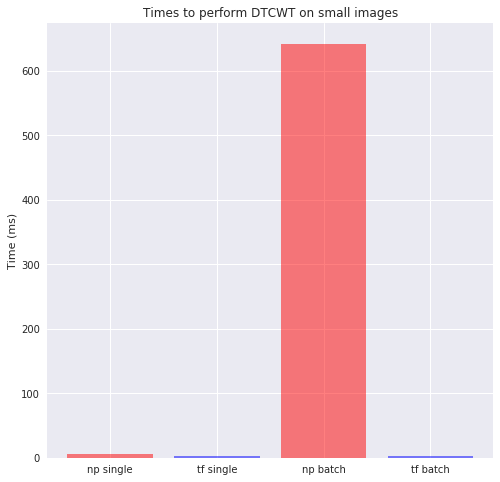

In [10]:
objects = ('np single', 'tf single', 'np batch', 'tf batch')
y_pos = np.arange(len(objects))
performance = [small_np.average, small_tf.average, small_np_batch.average, small_tf_batch.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(8,8))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform DTCWT on small images')
plt.show()

# Analysis of Large Images

## DTCWT on a single large image (512x512)

In [11]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
fwd = dtcwt.Transform2d()        # Numpy Transform
fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform

in_placeholder = tf.placeholder(tf.float32, [None, h, w])
out_tf = fwd_tf.forward(in_placeholder, nlevels=nlevels)
out_fft = tf.fft2d(tf.cast(in_placeholder, tf.complex64))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Numpy Implementation

In [12]:
large_np = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels)

57.3 ms ± 5.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### TF implementation

In [13]:
large_tf = %timeit -o sess.run(out_tf.lowpass_op, {in_placeholder: in_})

2.39 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### (Comparison) Using an FFT in Tensorflow

In [14]:
%timeit sess.run(out_fft, {in_placeholder: in_})

6.19 ms ± 325 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## DTCWT on a batch of large images (100x512x512)
Batches are something tensorflow naturally handles. This should widen the gap as we only have to copy data to the GPU once for multiple images

In [15]:
in_ = np.random.randn(100,512,512)

### Numpy Implementation

In [16]:
large_np_batch = %timeit -o for i in in_: fwd.forward(i, nlevels=nlevels).lowpass

5.44 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### TF implementation

In [17]:
large_tf_batch = %timeit -o  sess.run(out_tf.lowpass_op, {in_placeholder: in_})

124 ms ± 4.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### (Comparison) Using an FFT in Tensorflow

In [18]:
%timeit sess.run(out_fft, {in_placeholder: in_})

113 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## DTCWT on a batch of large images with a convolution afterwards
This again should widen the gap, as having already calculated something on the GPU, we don't need to transfer the data there again

In [19]:
h, w = 512, 512
in_ = np.random.randn(100, h, w)

### Numpy Implementation

In [20]:
fwd = dtcwt.Transform2d()
tf.reset_default_graph()
sess = tf.Session()
highs = tf.placeholder(tf.float32, [None, h>>3, w>>3, 6])
weights = tf.get_variable('weights', shape=(5,5,6,64))
step = tf.nn.conv2d(highs, weights, strides=[1,1,1,1], padding='SAME')
sess.run(tf.global_variables_initializer())

In [21]:
large_np_conv = %timeit -o sess.run(step, {highs: [abs(fwd.forward(i, nlevels=3).highpasses[2]) for i in in_]})

5.7 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### TF Implementation

In [22]:
tf.reset_default_graph()
in_placeholder = tf.placeholder(tf.float32, [None, h, w])
fwd_tf = dtcwt.tf.Transform2d() 
out_tf = fwd_tf.forward(in_placeholder, nlevels=3)
p = tf.abs(out_tf.highpasses_ops[2])
weights = tf.get_variable('weights', shape=(5,5,6,64))
out = tf.nn.conv2d(p, weights, strides=[1,1,1,1], padding='SAME')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [23]:
large_tf_conv = %timeit -o sess.run(out, {in_placeholder: in_})

143 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Running DTCWT with TF backend on a CPU
Perhaps there is still a speed-up when using a CPU and tensorflow?

In [45]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(1,h,w)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
with tf.device("/cpu:0"):
    fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform
    in_placeholder = tf.placeholder(tf.float32, [None, h, w])
    out_tf = fwd_tf.forward(in_placeholder, nlevels=nlevels)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
large_tf_cpu = %timeit -o  sess.run(out_tf.lowpass_op, {in_placeholder: in_})

12.8 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
in_ = np.random.randn(100,h,w)
large_tf_batch_cpu = %timeit -o  sess.run(out_tf.lowpass_op, {in_placeholder: in_})

516 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
tf.reset_default_graph()
with tf.device("/cpu:0"):
    in_placeholder = tf.placeholder(tf.float32, [None, h, w])
    fwd_tf = dtcwt.tf.Transform2d() 
    out_tf = fwd_tf.forward(in_placeholder, nlevels=3)
    p = tf.abs(out_tf.highpasses_ops[2])
    weights = tf.get_variable('weights', shape=(5,5,6,64))
    out = tf.nn.conv2d(p, weights, strides=[1,1,1,1], padding='SAME')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
large_tf_conv_cpu = %timeit -o sess.run(out, {in_placeholder: in_})

610 ms ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Large Image Conclusion

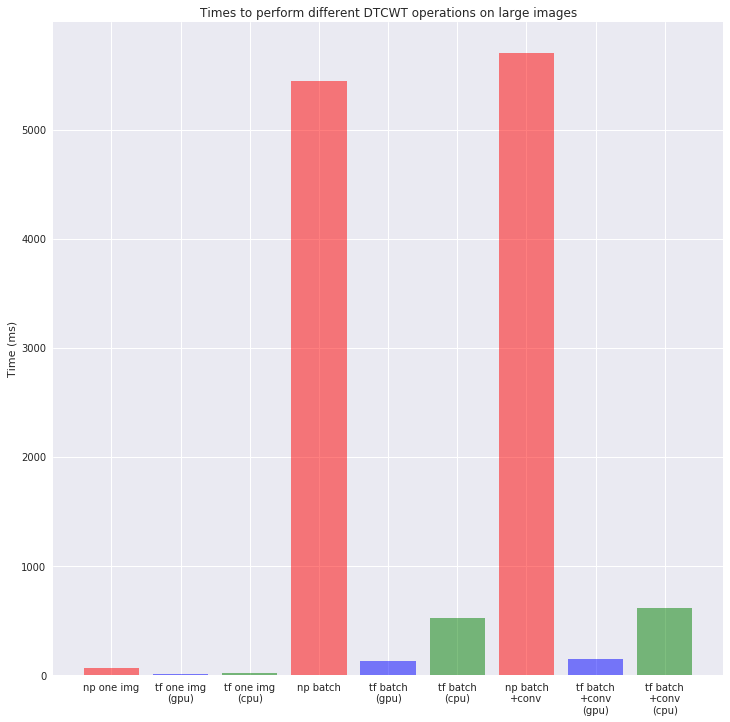

In [50]:
objects = ('np one img', 'tf one img\n(gpu)', 'tf one img\n(cpu)', 'np batch', 'tf batch\n(gpu)', 
           'tf batch\n(cpu)', 'np batch\n+conv', 'tf batch\n+conv\n(gpu)', 'tf batch\n+conv\n(cpu)')
y_pos = np.arange(len(objects))
performance = [large_np.average, large_tf.average, large_tf_cpu.average, 
               large_np_batch.average, large_tf_batch.average, large_tf_batch_cpu.average,
               large_np_conv.average, large_tf_conv.average, large_tf_conv_cpu.average]
performance = [i*1000 for i in performance]
fig, ax = plt.subplots(1, figsize=(12,12))
ax.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue', 'green'])
plt.xticks(y_pos, objects)
plt.ylabel('Time (ms)')
plt.title('Times to perform different DTCWT operations on large images')
plt.show()

# Comparison to Convolutions
One important distinguising feature that would be nice would be to see a speed-up in using the dtcwt over using convolutions.

## First we can compare execution time on a CPU

In [20]:
session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=1,
      inter_op_parallelism_threads=1,
      device_count={'CPU': 1})

In [24]:
# Create the input
h, w = 512, 512
in_ = np.random.randn(100,h,w,3)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
with tf.device("/cpu:0"):
    fwd_tf = dtcwt.tf.Transform2d()  # Tensorflow Transform
    in_placeholder = tf.placeholder(tf.float32, [None, h, w, 3])
    Yl, Yh = fwd_tf.forward_channels(in_placeholder, nlevels=nlevels)

sess = tf.Session(config=session_conf)
sess.run(tf.global_variables_initializer())

start = time.time()
#dtcwt_cpu = %timeit -o  sess.run(Yl, {in_placeholder: in_})
sess.run(Yl, {in_placeholder: in_})
print(time.time()-start)

2.2268359661102295


In [17]:
# Hard to say what an equivalent is? Let us compare to a single layer with 5x5x3x64
h, w = 512, 512
in_ = np.random.randn(100,h,w,3)

# Set up the transforms
nlevels = 3
tf.reset_default_graph()
with tf.device("/cpu:0"):
    in_placeholder = tf.placeholder(tf.float32, [None, h, w, 3])
    weights = tf.get_variable('weights', shape=(10,10,3,64))
    out = tf.nn.conv2d(in_placeholder, weights, strides=[1,1,1,1], padding='SAME')

sess = tf.Session(config=session_conf)
sess.run(tf.global_variables_initializer())
dtcwt_cpu = %timeit -o  sess.run(out, {in_placeholder: in_})

6.17 s ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
